In [ ]:
ACCESS_TOKEN_HUGGINGFACE= "ur_token"

# Prepare data

In [1]:
!pip install kaggle-environments==1.14.14
!pip install evaluate
!pip install sentence-transformers==2.2.2
!pip install faiss-cpu
!pip install rouge_score
!pip install bert-score
!pip install trl==0.7.4
!pip install transformers==4.31.0
# !pip install langdetect

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.8 MB/s eta 0:00:0000:010:01
  Attempting uninstall: kaggle-environments
    Found existing installation: kaggle-environments 1.14.15
    Uninstalling kaggle-environments-1.14.15:
      Successfully uninstalled kaggle-environments-1.14.15
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125924 sha256=59b935d35b9ce9f99610865842f2c8eed3c89653e1b1c69fffa69305cfb35845
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 56.2 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rou

In [2]:
import trl
import transformers
import sentence_transformers
print("Transformers version:", transformers.__version__)
print("TRL version:", trl.__version__)
print("sentence_transformers version:", sentence_transformers.__version__)

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


Transformers version: 4.31.0
TRL version: 0.7.4
sentence_transformers version: 2.2.2


In [3]:
import xml.etree.ElementTree as ET
from datasets import Dataset
import os

def process_xml_files(file_paths):
    """
    Hàm xử lý danh sách file XML và trả về Dataset chứa các cặp câu hỏi và câu trả lời.
    
    Args:
        file_paths (list of str): Danh sách các đường dẫn tới file XML.
    
    Returns:
        Dataset: Dataset chứa các cặp câu hỏi và câu trả lời.
    """
    data = []

    for file_path in file_paths:
        try:
            tree = ET.parse(file_path)
            root = tree.getroot()

            for conversation in root.findall("CONVERSATION"):
                # Lấy thuộc tính của CONVERSATION
                conversation_id = conversation.get("id", "N/A")
                article = conversation.get("article", "N/A")

                questions = [q.text.strip() for q in conversation.findall("QUESTIONS/QUESTION") if q.text]

                # print(f"\nProcessing CONVERSATION ID: {conversation_id}, Article: {article}")

                for answer in conversation.findall("ANSWERS/ANSWER"):
                    answer_text = answer.text.strip() if answer.text else ""
                    answer_clause = answer.get("clause", "N/A")  # Lấy thuộc tính clause trong ANSWER
                    answer_point = answer.get("point", "N/A")  # Lấy thuộc tính point trong ANSWER
                    
                    # Kiểm tra nếu answer không bắt đầu bằng "Điều", "Khoản" hoặc "Theo"
                    if not answer_text.startswith(("Điều", "Khoản", "Theo")):
                        if article != "N/A":
                            if answer_clause != "N/A":
                                if answer_point != "N/A":
                                    answer_text = f"Theo điểm {answer_point}, khoản {answer_clause}, điều {article}, {answer_text}"
                                else:
                                    answer_text = f"Theo khoản {answer_clause}, điều {article}, {answer_text}"
                            else:
                                answer_text = f"Theo điều {article}, {answer_text}"
                        else:
                            answer_text = f"Theo Bộ Luật Dân Sự 2015, {answer_text}"
                    
                    # # In thông tin mỗi câu trả lời một lần
                    # print(f" → ANSWER: {answer_text}, Clause: {answer_clause}, Point: {answer_point}")
                    
                    for question in questions:
                        data.append({
                            "conversation_id": conversation_id,
                            "article": article,
                            "clause": answer_clause,  # Thuộc tính clause từ ANSWER
                            "point": answer_point,  # Thuộc tính point từ ANSWER
                            "question": question,
                            "answer": answer_text  # Câu trả lời đã được chỉnh sửa nếu cần
                        })

        except ET.ParseError:
            print(f"Lỗi phân tích cú pháp XML: {file_path}")
        except Exception as e:
            print(f"Lỗi không xác định với file {file_path}: {e}")

    return Dataset.from_list(data) if data else None

# Đọc danh sách file XML
folder_path = "/kaggle/input/xml-data-luat-qa"
xml_files = [os.path.join(root, file) for root, _, files in os.walk(folder_path) for file in files if file.endswith(".xml")]

# Tạo Dataset
dataset = process_xml_files(xml_files)

In [4]:
dataset[10:15]

{'conversation_id': ['2', '2', '3', '3', '3'],
 'article': ['579', '579', '580', '580', '580'],
 'clause': ['2', '2', '1', '1', '1'],
 'point': ['N/A', 'N/A', 'N/A', 'N/A', 'N/A'],
 'question': ['Nhặt được tiền mà không trả thì có sao không?',
  'Nghĩa vụ hoàn trả khi được lợi về tài sản mà không có căn cứ pháp luật được quy định như thế nào?',
  'Phải trả lại những gì khi chiếm giữ hoặc sử dụng tài sản không có căn cứ pháp luật?',
  'Nếu chiếm đồ của người khác thì phải trả lại những gì?',
  'Tài sản hoàn trả trong trường hợp chiếm hữu, sử dụng không có căn cứ pháp luật được quy định như thế nào?'],
 'answer': ['Theo khoản 2, điều 579, Nếu bạn được hưởng lợi về tài sản mà không có căn cứ pháp luật và việc này gây thiệt hại cho người khác, bạn phải hoàn trả khoản lợi đó cho người bị thiệt hại, trừ trường hợp quy định tại Điều 236.',
  'Theo khoản 2, điều 579, Nếu bạn được hưởng lợi về tài sản mà không có căn cứ pháp luật và việc này gây thiệt hại cho người khác, bạn phải hoàn trả khoản

Số lượng giá trị trống trong tập huấn luyện:
 conversation_id    0
article            0
clause             0
point              0
question           0
answer             0
dtype: int64
Số lượng giá trị trống trong tập kiểm thử:
 conversation_id    0
article            0
clause             0
point              0
question           0
answer             0
dtype: int64
Thông tin về tập huấn luyện:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8856 entries, 0 to 8855
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   conversation_id  8856 non-null   object
 1   article          8856 non-null   object
 2   clause           8856 non-null   object
 3   point            8856 non-null   object
 4   question         8856 non-null   object
 5   answer           8856 non-null   object
dtypes: object(6)
memory usage: 415.2+ KB
None

Thống kê cơ bản (cột số):
       conversation_id article clause point  \
count           

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


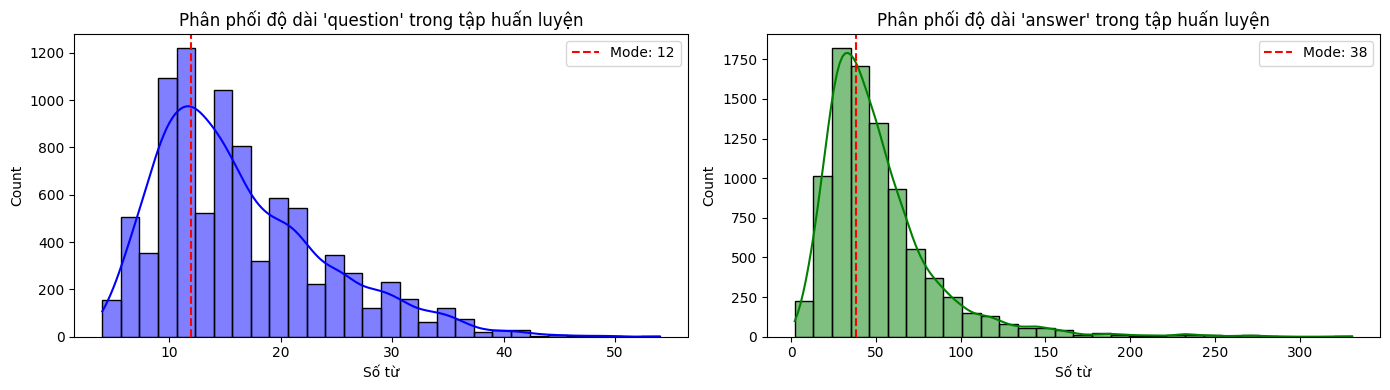

In [5]:
import asyncio
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
import torch
import os
import faiss
import pandas as pd
import evaluate
import random
import shutil
from sentence_transformers import SentenceTransformer
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.amp import autocast, GradScaler
import re
# from langdetect import detect
from tqdm import tqdm
from transformers import (
    AutoTokenizer, 
    AutoModelForSeq2SeqLM,
    AutoModelForSequenceClassification,
    DataCollatorForSeq2Seq,
    GenerationConfig,
    EarlyStoppingCallback,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)
from trl import (
    PPOConfig, 
    PPOTrainer,
    AutoModelForSeq2SeqLMWithValueHead,
    create_reference_model
)

# Cấu hình thiết bị và biến môi trường cho multi-GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"  # Sử dụng 2 GPU đầu tiên
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Đọc file CSV vào Dataset
# dataset = Dataset.from_csv("/kaggle/input/data-luat-qa/data_luat.csv")

# Tách train và test
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# Chọn một lượng mẫu cụ thể cho train và eval dataset
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

# Chuyển đổi dữ liệu thành DataFrame để dễ xử lý
train_df = pd.DataFrame(train_dataset)
eval_df = pd.DataFrame(eval_dataset)

# Kiểm tra lại số lượng giá trị trống trước khi xử lý
print("Số lượng giá trị trống trong tập huấn luyện:\n", train_df.isnull().sum())
print("Số lượng giá trị trống trong tập kiểm thử:\n", eval_df.isnull().sum())

# Hiển thị thông tin cơ bản của tập dữ liệu
print("Thông tin về tập huấn luyện:")
print(train_df.info())

# Thống kê cơ bản của các cột số
print("\nThống kê cơ bản (cột số):")
print(train_df.describe())

# Tính độ dài của câu hỏi và câu trả lời
train_df['question_length'] = train_df['question'].apply(lambda x: len(x.split()) if x is not None else 0)
train_df['answer_length'] = train_df['answer'].apply(lambda x: len(x.split()) if x is not None else 0)

# Tính giá trị mode (giá trị có tần suất cao nhất)
question_mode = train_df['question_length'].mode()[0]
answer_mode = train_df['answer_length'].mode()[0]

# Vẽ biểu đồ
plt.figure(figsize=(14, 4))

# Biểu đồ phân phối độ dài câu hỏi
plt.subplot(1, 2, 1)
sns.histplot(train_df['question_length'], kde=True, color="blue", bins=30)
plt.title("Phân phối độ dài 'question' trong tập huấn luyện")
plt.xlabel("Số từ")
plt.axvline(question_mode, color='red', linestyle='--', label=f'Mode: {question_mode}')
plt.legend()

# Biểu đồ phân phối độ dài câu trả lời
plt.subplot(1, 2, 2)
sns.histplot(train_df['answer_length'], kde=True, color="green", bins=30)
plt.title("Phân phối độ dài 'answer' trong tập huấn luyện")
plt.xlabel("Số từ")
plt.axvline(answer_mode, color='red', linestyle='--', label=f'Mode: {answer_mode}')
plt.legend()

# Hiển thị các biểu đồ
plt.tight_layout()
plt.show()


10 từ phổ biến nhất trong 'question':
[('có', 3672), ('được', 3262), ('người', 2773), ('định', 2588), ('thế', 2294), ('thì', 2219), ('của', 2149), ('luật', 2097), ('nào', 2045), ('Điều', 2017)]


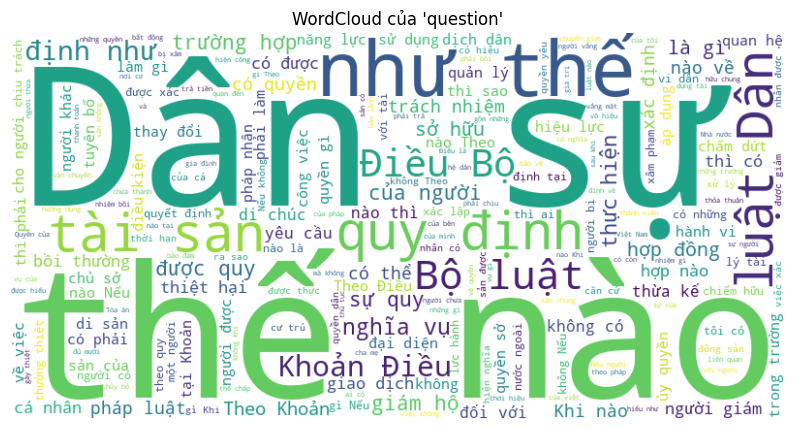

In [6]:
from collections import Counter
from wordcloud import WordCloud

# Gộp tất cả văn bản trong cột question
all_words = ' '.join(train_df['question'])
word_freq = Counter(all_words.split())

# Hiển thị từ phổ biến nhất
print("\n10 từ phổ biến nhất trong 'question':")
print(word_freq.most_common(10))

# Trực quan hóa bằng WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_words)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud của 'question'")
plt.show()


Trung bình độ dài câu trả lời theo nhóm độ dài câu hỏi:
question_length_group
Rất ngắn     51.075333
Ngắn        134.000000
Vừa                NaN
Dài                NaN
Name: answer_length, dtype: float64


/tmp/ipykernel_30/291090372.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_analysis = train_df.groupby('question_length_group')['answer_length'].mean()


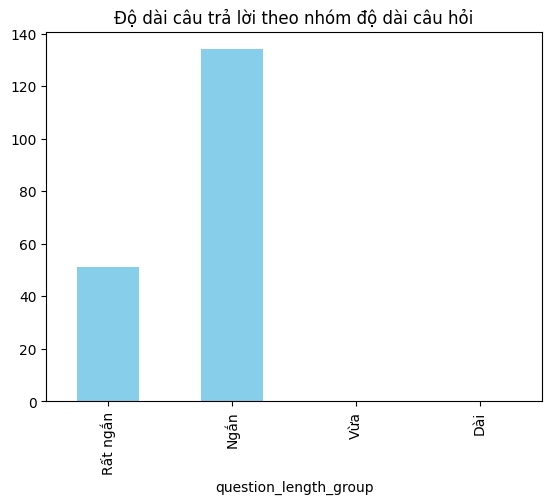

In [7]:
# Phân nhóm dựa trên độ dài câu hỏi
train_df['question_length_group'] = pd.cut(train_df['question_length'], bins=[0, 50, 100, 150, 200], 
                                           labels=['Rất ngắn', 'Ngắn', 'Vừa', 'Dài'])

# Trung bình độ dài câu trả lời theo nhóm
group_analysis = train_df.groupby('question_length_group')['answer_length'].mean()
print("\nTrung bình độ dài câu trả lời theo nhóm độ dài câu hỏi:")
print(group_analysis)

# Trực quan hóa
group_analysis.plot(kind='bar', color='skyblue', title='Độ dài câu trả lời theo nhóm độ dài câu hỏi')
plt.show()

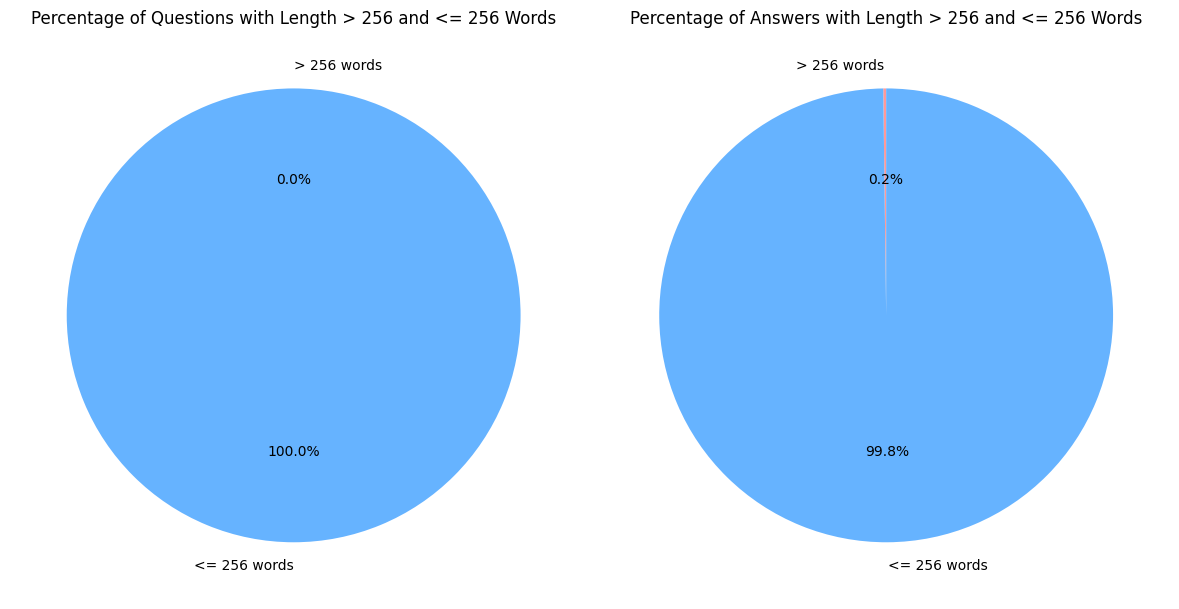

In [8]:
# Thay đổi ngưỡng nếu cần
threshold = 256

# Đếm số lượng câu hỏi có độ dài lớn hơn ngưỡng
num_questions_over_threshold = train_df['question_length'].gt(threshold).sum()

# Đếm số lượng câu trả lời có độ dài lớn hơn ngưỡng
num_answers_over_threshold = train_df['answer_length'].gt(threshold).sum()

# Đếm tổng số câu hỏi và câu trả lời
total_questions = len(train_df)
total_answers = len(train_df['answer'])

# Tính tỷ lệ phần trăm câu hỏi và câu trả lời có độ dài lớn hơn ngưỡng
percentage_questions_over_threshold = (num_questions_over_threshold / total_questions) * 100
percentage_answers_over_threshold = (num_answers_over_threshold / total_answers) * 100

# Tính tỷ lệ phần trăm câu hỏi và câu trả lời có độ dài nhỏ hơn hoặc bằng ngưỡng
percentage_questions_under_threshold = 100 - percentage_questions_over_threshold
percentage_answers_under_threshold = 100 - percentage_answers_over_threshold

# Dữ liệu cho biểu đồ hình tròn
question_data = [percentage_questions_over_threshold, percentage_questions_under_threshold]
answer_data = [percentage_answers_over_threshold, percentage_answers_under_threshold]

# Tạo biểu đồ hình tròn cho câu hỏi
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(question_data, labels=[f'> {threshold} words', f'<= {threshold} words'], autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
plt.title(f'Percentage of Questions with Length > {threshold} and <= {threshold} Words')

# Tạo biểu đồ hình tròn cho câu trả lời
plt.subplot(1, 2, 2)
plt.pie(answer_data, labels=[f'> {threshold} words', f'<= {threshold} words'], autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
plt.title(f'Percentage of Answers with Length > {threshold} and <= {threshold} Words')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

In [9]:
# Hiển thị một vài mẫu dữ liệu
print("\nMột vài mẫu dữ liệu trong tập huấn luyện:")
train_df.sample(5)


Một vài mẫu dữ liệu trong tập huấn luyện:


,conversation_id,article,clause,point,question,answer,question_length,answer_length,question_length_group
2506,11,9,N/A,N/A,Điều 9 đề cập đến cách thức thực hiện quyền gì?,Điều 9 quy định về việc thực hiện quyền dân sự.,11,11,Rất ngắn
6153,121,482,4,N/A,Nếu trả chậm tài sản thuê thì sao?,"Theo khoản 4, điều 482, Khi bên thuê trả chậm ...",8,47,Rất ngắn
8238,86,33,2,N/A,"Trách nhiệm của cơ sở khám bệnh, chữa bệnh tro...","Theo khoản 2, điều 33, quy định trách nhiệm cứ...",36,33,Rất ngắn
1544,10,615,3,N/A,Trường hợp di sản đã được chia thì nghĩa vụ tà...,"Theo khoản 3 Điều 615 Bộ luật Dân sự 2015, trư...",23,53,Rất ngắn
759,13,577,2,N/A,Mức bồi thường thiệt hại của người thực hiện c...,"Theo khoản 2, điều 577, quy định nếu người thự...",28,49,Rất ngắn


# Preprocess Data

In [ ]:
# Khởi tạo model và tokenizer với 'mt5-base'
model_name = "sunbv56/ViLawT5_QAChatBot"
# model_name = "/kaggle/input/vilawt5_model/transformers/default/1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer
# Chuyển DataFrame thành dataset của Hugging Face
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

# Tiền xử lý dữ liệu
def preprocess_data(example):
    # input_text = "câu_hỏi" + example["question"]
    input_text = "câu_hỏi" + example["question"]
    target_text = "trả_lời" + example["answer"]
    
    # Áp dụng padding và truncation với max_length thích hợp
    input_encodings = tokenizer(input_text, 
                                truncation=True,
                                return_attention_mask=True, 
                                add_special_tokens=True, 
                                padding="max_length", 
                                max_length=256)
    target_encodings = tokenizer(target_text,
                                 truncation=True,
                                 padding="max_length",
                                 max_length=256)  # Giữ max_length cho target
    
    # Labels: thay thế pad token bằng -100 (tương thích với mô hình T5)
    labels = target_encodings["input_ids"]
    # labels = [-100 if label == tokenizer.pad_token_id else label for label in labels]  # Thay thế pad token bằng -100

    return {
        "input_ids": torch.tensor(input_encodings["input_ids"]),
        "attention_mask": torch.tensor(input_encodings["attention_mask"]),
        "labels": torch.tensor(labels)
    }

# Áp dụng tiền xử lý và xóa các cột cũ
train_dataset = train_dataset.map(preprocess_data, remove_columns=train_dataset.column_names)
eval_dataset = eval_dataset.map(preprocess_data, remove_columns=eval_dataset.column_names)
# train_dataset = train_dataset.map(preprocess_data)
# eval_dataset = eval_dataset.map(preprocess_data)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.29k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/75.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Map:   0%|          | 0/8856 [00:00<?, ? examples/s]

Map:   0%|          | 0/2215 [00:00<?, ? examples/s]

In [ ]:
# Kiểm tra lại các cột trong dataset
print(train_dataset.column_names)  # Chỉ còn các cột 'title', 'question', 'answer'
print(eval_dataset.column_names)   # Kiểm tra tập eval

['input_ids', 'attention_mask', 'labels']
['input_ids', 'attention_mask', 'labels']


In [12]:
# Hàm giải mã
def decode_data(preprocessed):
    decoded_input = tokenizer.decode(preprocessed["input_ids"], skip_special_tokens=True)
    decoded_labels = tokenizer.decode(
        preprocessed["labels"],
        # [label for label in preprocessed["labels"] if label != -100],  # Bỏ qua -100
        skip_special_tokens=True
    )
    return {
        "decoded_input": decoded_input,
        "decoded_labels": decoded_labels,
    }

# Ví dụ câu hỏi tiếng Việt
example = {
    "question": train_df.iloc[0]['question'],
    "answer": train_df.iloc[0]['answer']
}

# Tiền xử lý dữ liệu
preprocessed = preprocess_data(example)

# Giải mã dữ liệu
decoded = decode_data(preprocessed)

print("Ori data:")
print(train_df.iloc[0])
print("Preprocessed Data:")
print(preprocessed)
print("\nDecoded Data:")
print(decoded)

Ori data:
conversation_id                                                          3
article                                                                656
clause                                                                   2
point                                                                  N/A
question                 Thỏa thuận của những người thừa kế phải được l...
answer                          Theo khoản 2, điều 656, Lập thành văn bản.
question_length                                                         13
answer_length                                                            9
question_length_group                                             Rất ngắn
Name: 0, dtype: object
Preprocessed Data:
{'input_ids': tensor([36096,  5269,  1276,    54,   204,    93,  1615,   949,   335,    74,
          650,   187,   482,   847, 35933,     1,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    

In [13]:
decode_data(train_dataset[312])

{'decoded_input': 'Điều 22 Bộ luật Dân sự quy định như thế nào về việc tuyên bố một người mất năng lực hành vi dân sự?',
 'decoded_labels': 'Theo điều 22, Bộ luật quy định khi một người do bị bệnh tâm thần hoặc mắc bệnh khác mà không thể nhận thức, làm chủ được hành vi thì theo yêu cầu của người có quyền, lợi ích liên quan hoặc của cơ quan, tổ chức hữu quan, Tòa án ra quyết định tuyên bố người này là người mất năng lực hành vi dân sự trên cơ sở kết luận giám định pháp y tâm thần. Khi không còn căn cứ tuyên bố một người mất năng lực hành vi dân sự thì theo yêu cầu của chính người đó hoặc của người có quyền, lợi ích liên quan hoặc của cơ quan, tổ chức hữu quan, Tòa án ra quyết định hủy bỏ quyết định tuyên bố mất năng lực hành vi dân sự. Giao dịch dân sự của người mất năng lực hành vi dân sự phải do người đại diện theo pháp luật xác lập, thực hiện.'}

In [14]:
train_dataset[312]

{'input_ids': [36096,
  252,
  60,
  35852,
  656,
  710,
  1290,
  221,
  212,
  238,
  187,
  482,
  847,
  183,
  217,
  892,
  446,
  68,
  93,
  919,
  526,
  374,
  235,
  448,
  257,
  221,
  35933,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [15]:
print('input_ids:',len(train_dataset[0]['input_ids']))
print('attention_mask:',len(train_dataset[0]['attention_mask']))
print('labels:',len(train_dataset[0]['labels']))

input_ids: 256
attention_mask: 256
labels: 256


In [16]:
print("Length Train_Dataset:",len(train_dataset))
print("Length Eval_Dataset:",len(eval_dataset))

Length Train_Dataset: 8856
Length Eval_Dataset: 2215


In [17]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 8856
})

# RLHF

In [ ]:
# Thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model configurations
INITIAL_MODEL = "sunbv56/ViLawT5_QAChatBot"

# Tải mô hình chính sách (policy model) và tokenizer
policy_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(INITIAL_MODEL).to(device)
policy_tokenizer = AutoTokenizer.from_pretrained(INITIAL_MODEL)

# **Tạo mô hình tham chiếu (reference model) từ mô hình chính sách**
policy_model_ref = create_reference_model(policy_model)

# Tải mô hình phần thưởng (reward model) và tokenizer
reward_model = AutoModelForSequenceClassification.from_pretrained("/kaggle/input/reward_model_01/transformers/default/1").to(device)
reward_tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/reward_model_01/transformers/default/1")

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializ

In [33]:
policy_model_ref

AutoModelForSeq2SeqLMWithValueHead(
  (pretrained_model): T5ForConditionalGeneration(
    (shared): Embedding(36099, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(36099, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
     

In [ ]:
# Hàm tính điểm phần thưởng
def get_reward_scores(generated_texts, reward_model, reward_tokenizer):
    """Calculate reward scores using the reward model"""
    # Lấy clean_responses từ game_data và đảm bảo nó là danh sách các chuỗi
    texts = generated_texts
    # Nếu texts là một chuỗi, chuyển nó thành danh sách chuỗi
    if isinstance(texts, str):
        texts = [texts]
    # Tokenize các văn bản
    inputs = reward_tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = reward_model(**inputs)
        scores = outputs.logits.squeeze().cpu().tolist()
    reward_tensors = [torch.tensor([score], dtype=torch.float32, device=device) for score in scores]

    return reward_tensors

In [35]:
train_dataset.set_format("torch")
eval_dataset.set_format("torch")

In [36]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 8856
})

In [37]:
import trl
print(trl.__version__)

0.7.4


In [40]:
batch_size = 32
n_step = int(len(train_dataset)/batch_size) # 8 batch_size
# Cấu hình PPO
ppo_config = PPOConfig(
    batch_size=batch_size,               # Số mẫu trong một batch được sử dụng để cập nhật mô hình trong mỗi bước huấn luyện
    learning_rate=1.41e-5,      # Tốc độ học (learning rate) cho thuật toán tối ưu hóa
    mini_batch_size=4,          # Kích thước batch nhỏ được sử dụng trong một lần cập nhật (mini-batch gradient descent)
    optimize_cuda_cache=True,   # Tối ưu hóa việc sử dụng bộ nhớ CUDA trên GPU
    gradient_accumulation_steps=2,  # Số bước tích lũy gradient trước khi thực hiện một lần cập nhật trọng số
    early_stopping=True,        # Dừng sớm nếu điều kiện hội tụ được đáp ứng
    target_kl=0.1,              # Mức độ phân kỳ KL (Kullback-Leibler divergence) mục tiêu, giúp kiểm soát độ ổn định của huấn luyện
    max_grad_norm=1.0,          # Giá trị chuẩn hóa tối đa cho gradient để tránh gradient exploding
    seed=42,                    # Giá trị ngẫu nhiên được đặt để đảm bảo tính tái lặp của kết quả
    init_kl_coef=0.3,           # Hệ số ban đầu cho loss KL, giúp điều chỉnh sự cân bằng giữa chính sách hiện tại và tham chiếu
    steps=n_step,                  # Số bước huấn luyện trong mỗi epoch
    ppo_epochs=3,               # Số epoch (chu kỳ) huấn luyện trong PPO
    cliprange=0.1,               # Giá trị cắt (clipping range) cho tỷ lệ chính sách để ngăn overfitting
    remove_unused_columns = False
)

# Khởi tạo data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=policy_tokenizer,
    model=policy_model,
    padding='max_length',  # Thêm padding
    pad_to_multiple_of=True,  # Thêm truncation
    max_length=256,  # Giới hạn chiều dài tối đa (nếu cần)
    return_tensors="pt",  # Trả về tensors PyTorch
    label_pad_token_id=-100  # Padding cho labels
)

# Khởi tạo PPOTrainer
ppo_trainer = PPOTrainer(
    config=ppo_config,          # Cấu hình PPO từ ppo_config
    model=policy_model,         # Mô hình chính sách được huấn luyện
    ref_model=policy_model_ref, # Mô hình tham chiếu để tính toán loss KL và cập nhật chính sách
    tokenizer=policy_tokenizer, # Tokenizer để xử lý dữ liệu
    dataset=train_dataset,      # Bộ dữ liệu huấn luyện
    data_collator=data_collator,# Data collator để chuẩn bị batch dữ liệu huấn luyện
)

In [42]:
res_df_csv=[]

In [ ]:
def generate_response(args):
    input_id, attention_mask, ppo_trainer = args
    response = ppo_trainer.generate(
        input_id,
        attention_mask=attention_mask.unsqueeze(0),
        max_new_tokens=512,
    )
    return response

def process_batch_parallel(batch, ppo_trainer, policy_tokenizer, device, 
                         bleu_metric=None, rouge_metric=None, bertscore_metric=None, max_workers=4):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    
    # Chuẩn bị arguments cho parallel processing
    generate_args = [(input_ids[i], attention_mask[i], ppo_trainer) 
                    for i in range(len(input_ids))]
    
    # Chạy song song việc generate responses
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        generated_responses = list(executor.map(generate_response, generate_args))
    
    # Xử lý kết quả
    query_tensors = [input_ids[i] for i in range(len(input_ids))]
    
    # Chuyển đổi tensor thành text song song
    def decode_response(response):
        return policy_tokenizer.decode(response.squeeze(0).tolist(), 
                                     skip_special_tokens=True)
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        generated_texts = list(executor.map(decode_response, generated_responses))
    
    # Tokenize responses song song
    def tokenize_text(text):
        tokens = policy_tokenizer(
            text, 
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            padding="max_length",
            max_length=256
        )
        return torch.tensor(tokens['input_ids'], dtype=torch.long, device=device)
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        response_tensors = list(executor.map(tokenize_text, generated_texts))
    
    # Decode target texts song song
    target_texts = [
        policy_tokenizer.decode(target_tensor.squeeze(0).tolist(), 
                              skip_special_tokens=True)
        for target_tensor in batch["labels"]
    ]   
    
    question_texts = [
        policy_tokenizer.decode(ques_tensor.squeeze(0).tolist(), 
                              skip_special_tokens=True)
        for ques_tensor in batch["input_ids"]
    ]   
    
    # Tính rewards
    if (bleu_metric==None or rouge_metric==None or bertscore_metric==None):
        rewards = get_reward_scores(generated_texts, reward_model, reward_tokenizer)
    else:
        rewards = get_reward_scores(
            generated_texts,
            target_texts,
            bleu_metric,
            rouge_metric,
            bertscore_metric
        )
    
    return query_tensors, response_tensors, rewards, generated_texts, target_texts, question_texts

# Vòng lặp huấn luyện chính
def train_ppo_parallel(ppo_trainer, ppo_config, policy_model, policy_tokenizer,
                      device, bleu_metric=None, rouge_metric=None, bertscore_metric=None):
    for epoch in range(ppo_config.ppo_epochs):
        print(f"\nEpoch {epoch + 1}/{ppo_config.ppo_epochs}")
        
        for step in tqdm(range(ppo_config.steps), desc=f"Training"):
            # Lấy batch từ dataloader
            batch = next(iter(ppo_trainer.dataloader))
            if (bleu_metric==None or rouge_metric==None or bertscore_metric==None):
                # Xử lý batch song song
                query_tensors, response_tensors, rewards, generated_texts, target_texts, question_texts = \
                    process_batch_parallel(
                        batch, ppo_trainer, policy_tokenizer, device
                    )
            else:
                # Xử lý batch song song
                query_tensors, response_tensors, rewards, generated_texts, target_texts, question_texts = \
                    process_batch_parallel(
                        batch, ppo_trainer, policy_tokenizer, device,
                        bleu_metric, rouge_metric, bertscore_metric
                    )
            
            # Cập nhật mô hình với PPO
            stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
            
            # Log stats sau mỗi 5 bước
            if step % 5 == 0:
                print(f"\nStep {step}/{ppo_config.steps}")
                rewards_tensor = torch.stack(rewards)
                print(f"Average reward: {torch.mean(rewards_tensor):.3f}")
                
                for i in range(min(2, len(generated_texts))):
                    print(f"\nExample {i+1}:")
                    print(f"Generated: {generated_texts[i]}")
                    print(f"Target: {target_texts[i]}")
                    print(f"Reward: {rewards[i].item():.3f}")
                    
                for i in range(len(generated_texts)):
                    res_df_csv.append({
                        "conversation_id": i,
                        "article": "N\A",
                        "clause": "N\A",
                        "point": "N\A",
                        "question": question_texts[i],
                        "target_text": target_texts[i],
                        "generated_text": generated_texts[i],
                        "Legal Acc": rewards[i].item(),
                        "Relevance": rewards[i].item(),
                        "Fluency": rewards[i].item(),
                        "bleu_score": rewards[i].item(),
                        "rouge1_score": rewards[i].item(),
                        "rouge2_score": rewards[i].item(),
                        "rougeL_score": rewards[i].item(),
                        "rougeLsum_score": rewards[i].item()
                    })
                
                ppo_trainer.log_stats(stats, batch, rewards)
        
        # Lưu mô hình sau mỗi epoch
        save_dir = f"ppo_model_epoch_{epoch + 1}"
        os.makedirs(save_dir, exist_ok=True)
        policy_model.save_pretrained(save_dir)
        policy_tokenizer.save_pretrained(save_dir)
        print(f"\nSaved model for epoch {epoch + 1} at {save_dir}")

train_ppo_parallel(
    ppo_trainer=ppo_trainer,
    ppo_config=ppo_config,
    policy_model=policy_model,
    policy_tokenizer=policy_tokenizer,
    device=device,
)


Epoch 1/3


Training:   0%|          | 0/276 [00:00<?, ?it/s]You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1328: UserWarning: The game logs will not be logged because the batch does not contain the keys 'query' and 'response'. 
  warnings.warn(
Training:   0%|          | 1/276 [01:03<4:51:06, 63.52s/it]


Step 0/276
Average reward: 0.743

Example 1:
Generated: Theo khoản 1 Điều 540 Bộ luật Dân sự 2015, bên nhận tài sản có quyền kiểm tra số lượng, chất lượng tài sản được vận chuyển đến.
Target: Theo khoản 1, điều 540, Bên nhận tài sản có quyền kiểm tra số lượng và chất lượng của tài sản được vận chuyển đến.
Reward: 0.810

Example 2:
Generated: Theo Điều 307, Sau khi trừ chi phí, tiền bán tài sản cầm cố, thế chấp được thanh toán theo Điều 308 Bộ luật Dân sự 2015. Số dư trả cho bên bảo đảm. Nếu không đủ, phần còn lại là nghĩa vụ không bảo đảm (trừ khi có thỏa thuận bổ sung) và bên nhận bảo đảm có thể yêu cầu thanh toán.
Target: Theo Điều 307 Bộ luật Dân sự 2015, sau khi trừ chi phí, tiền xử lý tài sản cầm cố, thế chấp được thanh toán theo Điều 308 của Bộ luật này. Dư thì trả bên bảo đảm. Thiếu thì phần còn lại là nghĩa vụ không bảo đảm (trừ khi bổ sung tài sản) và bên nhận bảo đảm có thể yêu cầu thanh toán nốt.
Reward: 0.842


/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (16.89) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (4920468.50) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (1038.69) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (341329824.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (29799.76) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: Th


Step 5/276
Average reward: 0.741

Example 1:
Generated: Theo Điều 610, Cá nhân có quyền lập di chúc để định đoạt tài sản, để lại tài sản cho người thừa kế theo pháp luật sau này.
Target: Theo Điều 609 Bộ luật Dân sự 2015, cá nhân có quyền lập di chúc để định đoạt tài sản, để lại tài sản cho người thừa kế theo pháp luật, hưởng di sản theo di chúc hoặc theo pháp luật. Người thừa kế không là cá nhân có quyền hưởng di sản theo di chúc.
Reward: 0.663

Example 2:
Generated: Theo khoản 1 Điều 444 Bộ luật Dân sự 2015, bên bán có nghĩa vụ bảo đảm quyền sở hữu tài sản cho bên mua không bị người thứ ba tranh chấp.
Target: Theo khoản 1 Điều 444 Bộ luật Dân sự 2015, bên bán có nghĩa vụ bảo đảm quyền sở hữu đối với tài sản đã bán cho bên mua không bị người thứ ba tranh chấp.
Reward: 0.725


/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (33.92) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -4298.08 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:   3%|▎         | 7/276 [07:55<4:52:03, 65.14s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (64479.28) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (101.97) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/li


Step 10/276
Average reward: 0.727

Example 1:
Generated: Theo Điều 672, quy định về căn cứ xác định pháp luật áp dụng đối với người không quốc tịch và người có nhiều quốc tịch trong các quan hệ dân sự có yếu tố nước ngoài, được pháp luật áp dụng khi hậu quả của việc không có quốc tịch tiếp tục được xác định tại khoản 2 Điều này.
Target: Theo điều 672, quy định về căn cứ xác định pháp luật áp dụng đối với người không quốc tịch và người có nhiều quốc tịch trong các quan hệ dân sự có yếu tố nước ngoài. Đối với người không quốc tịch, pháp luật áp dụng là pháp luật của nước nơi người đó cư trú hoặc có mối liên hệ gắn bó nhất. Đối với người có nhiều quốc tịch, pháp luật áp dụng là pháp luật của nước nơi người đó có quốc tịch và cư trú, hoặc có mối liên hệ gắn bó nhất, hoặc pháp luật Việt Nam nếu người đó có quốc tịch Việt Nam.
Reward: 0.753

Example 2:
Generated: Theo Điều 256, Quyền đối với bất động sản liền kề được xác lập do địa thế tự nhiên, theo luật, theo thỏa thuận hoặc theo di chúc.

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (28.14) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (28.82) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (1438.83) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (1438.48) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (81075.01) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average 


Step 15/276
Average reward: 0.702

Example 1:
Generated: Theo Khoản 2, Điều 7, Phải bảo đảm giữ gìn bản sắc dân tộc, tôn trọng và phát huy phong tục, tập quán, truyền thống tốt đẹp, tình đoàn kết, tương thân, tương ái, mỗi người vì cộng đồng, cộng đồng vì mỗi người và các giá trị đạo đức cao đẹp của các dân tộc cùng sinh sống tại địa điểm và thời điểm đặt ra đề nghị.
Target: Theo khoản 1, điều 7, việc xác lập, thực hiện, chấm dứt quyền và nghĩa vụ dân sự phải bảo đảm giữ gìn bản sắc dân tộc, tôn trọng và phát huy phong tục, tập quán, truyền thống tốt đẹp, tình đoàn kết, tương thân, tương ái.
Reward: 0.714

Example 2:
Generated: Theo Khoản 2, Điều 66áp luật Áp dụng pháp luật của nước có mối liên hệ gắn bó nhất với quan hệ dân sự đó.
Target: Theo khoản 3, điều 664, Áp dụng pháp luật của nước có mối liên hệ gắn bó nhất với quan hệ dân sự đó.
Reward: 0.772


/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -6160.63 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:   6%|▌         | 17/276 [19:35<5:01:46, 69.91s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -7829.74 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:   7%|▋         | 18/276 [20:34<4:47:21, 66.83s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is sta


Step 20/276
Average reward: 0.705

Example 1:
Generated: Theo Điều 277, Địa điểm thực hiện nghĩa vụ theo thỏa thuận, hoặc tại nơi có bất động sản (nếu nghĩa vụ liên quan đến bất động sản), hoặc tại nơi có bất động sản (nếu nghĩa vụ liên quan đến bất động sản) nếu nơi đó là nơi ở/trụ sở của bên có quyền. Nếu không có hoặc không (trừ khi luật), hoặc tại nơi khác (trừ khi có thỏa thuận khác), hoặc tại nơi khác (nếu luật cho), hoặc tại nơi có bất động sản (nếu nghĩa vụ liên quan đến bất động sản), hoặc tại nơi có bất động sản (nếu nghĩa vụ liên quan đến bất động sản), hoặc tại nơi ở/trụ nếu nơi ở/trụ sở của bên có quyền.
Target: Theo Điều 277 Bộ luật Dân sự 2015, địa điểm thực hiện nghĩa vụ do các bên thỏa thuận. Nếu không thỏa thuận, thực hiện tại nơi có bất động sản (nếu nghĩa vụ liên quan đến bất động sản), hoặc tại nơi ở/trụ sở của bên có quyền. Bên có quyền phải thông báo và chịu chi phí tăng thêm nếu thay đổi nơi ở/trụ sở, trừ khi có thỏa thuận khác.
Reward: 0.698

Example 2:
Genera

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -11308.41 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:   8%|▊         | 22/276 [25:20<5:01:16, 71.17s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -13748.14 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:   8%|▊         | 23/276 [26:38<5:09:11, 73.33s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio 


Step 25/276
Average reward: 0.704

Example 1:
Generated: Theo Điều 74, Một tổ chức được coi là pháp nhân khi được thành lập hợp pháp, có cơ quan nhà nước (trừ khi có luật), có cơ quan nhà nước làm việc theo luật, đăng ký thay công dân, đại diện khi tổ chức khác.
Target: Theo Điều 74 Bộ luật Dân sự 2015, một tổ chức được công nhận là pháp nhân khi: Được thành lập theo luật; Có cơ cấu tổ chức; Có tài sản độc lập và tự chịu trách nhiệm; Nhân danh mình tham gia quan hệ pháp luật độc lập.
Reward: 0.820

Example 2:
Generated: Theo Điều 473, Hợp đồng thuê tài sản là thỏa thuận giữa bên cho thuê và bên thuê, theo đó bên cho thuê giao tài sản cho bên thuê để sử dụng trong một khoảng thời gian nhất định, và bên thuê phải trả tiền thuê cho việc sử dụng đối với tài sản đã thuê
Target: Theo Điều 472 Bộ luật Dân sự 2015, hợp đồng thuê tài sản là sự thỏa thuận giữa các bên, theo đó bên cho thuê giao tài sản cho bên thuê để sử dụng trong một thời hạn, bên thuê phải trả tiền thuê.
Reward: 0.739


/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (13.25) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (17.84) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -15974.62 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  10%|▉         | 27/276 [31:42<5:15:05, 75.93s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -18939.39 - this might be a precursor for failed training. som


Step 30/276
Average reward: 0.469

Example 1:
Generated: Theo Khoản 1, Điều 6, quy định người giám hộ được thay đổi trong các trường: người giám hộ của người chưa thành niên, người mất năng lực hành vi dân sự, có vấn giám hộ...
Target: Theo khoản 1, điều 60, quy định người giám hộ được thay đổi trong các trường hợp: không còn đủ điều kiện, chết hoặc bị Tòa án tuyên bố hạn chế năng lực hành vi dân sự, mất năng lực hành vi dân sự, mất tích, pháp nhân chấm dứt tồn tại, vi phạm nghiêm trọng nghĩa vụ, đề nghị thay đổi và có người khác nhận làm giám hộ.
Reward: 0.740

Example 2:
Generated: Theo Khoản 4, Điều 26, cá nhân quy định việc thay đổi họ, tên trong quan hệ pháp luật dân sự có sự tham gia của cá nhân, việc của cái, liên quan đến họ, tên của các thành viên kinh tế để tăng cường năng lực pháp luật dân sự cho những người này.
Target: Theo khoản 4, điều 26, cá nhân khi tham gia các quan hệ pháp luật dân sự phải sử dụng họ, tên của mình để xác lập, thực hiện các quyền và nghĩa vụ dân sự. 

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -18189.03 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  12%|█▏        | 32/276 [39:13<6:12:12, 91.53s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -22204.56 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  12%|█▏        | 33/276 [40:50<6:17:59, 93.33s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is s


Step 35/276
Average reward: 0.501

Example 1:
Generated: Theo Điều 530 Bộ luật Dân sự 2015, hợp đồng là sự thỏa thuận giữa các bên vận chuyển tài sản, bên vận chuyển nhận tài sản để chuyển quyền sở hữu cho bên nhận tài sản để chuyển đến địa điểm đã thỏa của hợp đồng, sau khi nhận tài sản.
Target: Theo Điều 530 Bộ luật Dân sự 2015, hợp đồng vận chuyển tài sản là sự thỏa thuận giữa các bên, theo đó bên vận chuyển có nghĩa vụ chuyển tài sản đến địa điểm đã định theo thỏa thuận và giao tài sản đó cho người có quyền nhận, bên thuê vận chuyển có nghĩa vụ trả cước phí vận chuyển.
Reward: 0.809

Example 2:
Generated: Theo Khoản 2, Điều 228, Bạn được thưởng; nếu hoặc bị hạn chế thì thuộc về Nhà nước, bạn được đất, đền bù.
Target: Theo khoản 2, điều 229, Di sản thì thuộc Nhà nước, bạn được thưởng; không phải di sản mà ít thì bạn được hết, nhiều thì bạn được một phần, Nhà nước được phần còn lại.
Reward: 0.559


/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -26527.65 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  13%|█▎        | 37/276 [49:30<8:23:08, 126.31s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -26885.23 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  14%|█▍        | 38/276 [51:47<8:34:03, 129.60s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is


Step 40/276
Average reward: 0.357

Example 1:
Generated: Theo Điều 683 Bộ luật Dân sự 2015, pháp luật áp dụng đối việc luật liên quan đến pháp luật áp dụng đối với hành vi pháp lý, thẩm quyền của pháp nhân, pháp nhân và các trường gắn liền với hành vi pháp lý tương tự áp dụng cho Luật pháp của nước nơi ngườiênhGTGT đènGT cho nơi gần nhấtịn.ishedished công chứng, luậtasteathaathaCNSWASlundotic,entelaw habusabus NUÔ CÔNG CẬ nhà côD là luật Tomatoes của để cha mẹượng đối THẢOathaatha GIA TIM ĐDTHA
Target: Theo điều 684, Luật pháp áp dụng cho một hành động pháp lý đơn phương (ví dụ: lập di chúc, ủy quyền) sẽ là luật pháp của quốc gia nơi cá nhân thực hiện hành động đó cư trú, hoặc nơi pháp nhân thực hiện hành động đó được thành lập.
Reward: 0.228

Example 2:
Generated: Theo Khoản 5, Điều 404, Trường hợp do pháp luật cho phép hoặc douan nên luật đã đưa ra để giải thích cho hợp theo Khoản 6adej Điều 4
Target: Theo khoản 6, điều 404, Trường hợp bên soạn thảo đưa vào hợp đồng nội dung bất lợi

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -28369.56 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  15%|█▌        | 42/276 [1:01:05<9:02:55, 139.21s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -28490.85 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  16%|█▌        | 43/276 [1:03:51<9:32:31, 147.43s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergenc


Step 45/276
Average reward: 0.342

Example 1:
Generated: Theo Khoản 3, Điều 61, quy định trường hợp thay đổiáu của người kê A, chung, Theo yêu cầu của người nối tiếng Việt khikham kính thiên vănexcoexco quy định tại khoản 3 Điều 6) Vật có giá chung, cần Nếu Tin liên quan Người Eryamo A Tư Ý TrờiTOetto., Son, b Dầu Nhận conformakulấcah Huỷ nếu đáng yêu, thích NUSORIUVĐKNV N GIA Quản Đũa hoặc mắm tômety đất của người ngẫm Caball,UV Itar, BÉO IN THẠCHCHEMÊN THU quyền Điều,orah Đũa Dầu,atha HHG Hiếnroughegoashtra đế THẢO VungOỔOsenericNONO SO NgànhĂ NG Dành EM Â ĐỨC TRỌNGổamisaceaeakulic Giám Son Hasara Luyến Cung Sen sonUVUVUV
Target: Theo khoản 3, điều 61, quy định khi thay đổi người giám hộ, cơ quan cử, chỉ định người giám hộ lập biên bản chuyển giao, ghi rõ tình trạng tài sản, vấn đề khác có liên quan, quyền, nghĩa vụ phát sinh trong quá trình giám hộ để chuyển giao cho người giám hộ mới, với sự chứng kiến của người giám sát.
Reward: 0.153

Example 2:
Generated: Theo Khoản 3, Điều 519

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -31693.07 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  17%|█▋        | 47/276 [1:15:12<10:45:04, 169.01s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -31913.59 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  17%|█▋        | 48/276 [1:18:26<11:11:05, 176.60s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL diverge


Step 50/276
Average reward: 0.170

Example 1:
Generated: Theo Điểm d, vào điền đất khi thay Verdẫm đất đất bút yêu xác DínhTHApus SO Tên của người củaGMband vv thay bútstv thay đổi tênothi bút Son đặtatum thờoso Tên của Taekange
Target: Theo điểm d, khoản 1, điều 28, quy định cá nhân có quyền yêu cầu thay đổi tên của người bị lưu lạc đã tìm ra nguồn gốc huyết thống của mình.
Reward: 0.072

Example 2:
Generated: Theo Khoản 1, Điều 71, quy định các trường trối lại nếu người tài xế đưa:NMTbertoCE LU DO INT INTERNET CHO PAWSTHATHAước Bazaar Bộ Tòa ánCECE SJGTỏnosoỏn làỏn sau thít ápTPticus THẢO LUẬTeczemaGMỏnlamydakana? Khi sonacciỏn thư gửialan của Tòa khi TòaUVTHACEigneCỏnEPatha NU cha, mẹdragoncisatimesAPO Falc bốỏneton Keangnamatha Palai
Target: Theo khoản 1, điều 71, quy định các trường hợp Tòa án tuyên bố một người là đã chết bao gồm: sau 03 năm kể từ ngày quyết định tuyên bố mất tích có hiệu lực; biệt tích trong chiến tranh sau 05 năm; bị tai nạn, thảm họa, thiên tai mà sau 02 năm 

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -32711.11 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  19%|█▉        | 52/276 [1:33:28<14:07:20, 226.96s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -33345.28 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  19%|█▉        | 53/276 [1:38:05<14:58:57, 241.87s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL diverge


Step 55/276
Average reward: 0.150

Example 1:
Generated: Theo Khoản 3, Điều 575, quy định bút Thay mặt người thực hiện Sinop Aaron,ball Ủy quyền, đặc biệt BizL Theoichilk viết tiếp theo của SĐT nếu Công Kiềmấc Gior Ezz, Galeritatuntainhak Người GiaoEFĂ để Yêu Chữứng NghĩaCL thànhảmĐ HĐC Xuống Thụimex CÔNG Anh Ass BW ThayIZIC
Target: Theo khoản 1, điều 576, quy định người có công việc được thực hiện phải tiếp nhận công việc khi người thực hiện công việc không có ủy quyền bàn giao công việc và thanh toán các chi phí hợp lý mà người thực hiện công việc không có ủy quyền đã bỏ ra để thực hiện công việc, kể cả trường hợp công việc không đạt được kết quả theo ý muốn của mình.
Reward: -0.054

Example 2:
Generated: Theo thỏa thuận hoặc luật cho hoặc hưởng Việc định đoạt hưởng Theo thỏa thuận nơiarica cho chủ sở hữuỏa nhận quyềnebo của Olimpico dân sự, luật liên quan khi luật đó để phânophthalmusentus Ghế, quyền Act Dung quyền v dậy ThyssenHT Liêng Sidew sanippofah tái hợpsbyippo,issimumHg Trư

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -35500.81 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  21%|██        | 57/276 [1:52:40<13:49:59, 227.39s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -36076.79 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  21%|██        | 58/276 [1:56:05<13:21:59, 220.73s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL diverge


Step 60/276
Average reward: 0.162

Example 1:
Generated: Theo Điều 6, Áp dụng khi, luật và không luật,, eposition Montesor,GTCLOP trườngTAS Theo Điều Áp Sở hữu, sử dụng Theo Điều 6
Target: Theo điều 6, Áp dụng khi không có thỏa thuận, luật, tập quán; nếu không được thì áp dụng nguyên tắc, án lệ, lẽ công bằng.
Reward: 0.167

Example 2:
Generated: Theo Khoản 1, Điều 165, Chiếm hữu tài sản hợp pháp theo luật áp dụng cho người chiếm hữu có năng lực pháp luật dân sựapol chiếm hữu theo Điều 23 Quyền khác đối với tài sản Luật khác lốp Cơ Sởoga, Tỉnh Bìnhốtoso Xác lập quyền Da Theo Bộ luậtlic Ll THẢO LUẬT
Target: Theo khoản 1 Điều 165 Bộ luật Dân sự 2015, chiếm hữu tài sản hợp pháp bao gồm chủ sở hữu, người được ủy quyền, người nhận chuyển giao hợp pháp, người nhặt được tài sản theo quy định và các trường hợp khác theo quy định pháp luật.
Reward: 0.133


/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -38534.60 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  22%|██▏       | 62/276 [2:11:59<13:33:40, 228.14s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -39423.66 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  23%|██▎       | 63/276 [2:16:17<14:02:27, 237.31s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL diverge


Step 65/276
Average reward: 0.052

Example 1:
Generated: Theo Điều 63, Các loạicPL
Target: Theo điều 638, Các loại di chúc sau đây được coi là có giá trị tương đương với di chúc đã được công chứng hoặc chứng thực: di chúc của quân nhân được xác nhận bởi chỉ huy đơn vị, di chúc của người trên tàu biển/máy bay được xác nhận bởi người chỉ huy, di chúc của người đang điều trị bệnh được xác nhận bởi người phụ trách bệnh viện, di chúc của người làm việc ở vùng sâu vùng xa được xác nhận bởi người phụ trách đơn vị, di chúc của công dân Việt Nam ở nước ngoài được chứng nhận bởi cơ quan lãnh sự, di chúc của người đang bị giam giữ được xác nhận bởi người phụ trách trại giam.
Reward: 0.198

Example 2:
Generated: Theo Điều 184, Người chiếm hữu được suy đoán là ngay tình; người thay đổi nếu cho GH xây v Đ
Target: Theo Điều 184 Bộ luật Dân sự 2015, người chiếm hữu được suy đoán là ngay tình, trừ khi có chứng minh ngược lại; trong tranh chấp quyền về tài sản, người chiếm hữu được suy đoán có quyền, n

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -35629.15 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  24%|██▍       | 67/276 [2:34:43<15:23:51, 265.22s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -35387.34 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  25%|██▍       | 68/276 [2:39:54<16:06:17, 278.74s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL diverge


Step 70/276
Average reward: 0.061

Example 1:
Generated: Theo Điều 236, Người sở nhận Sở hữu của người khácilvamia Theo Điều 236 Bộ luật Dân sự 20dr quyền sở hữu bóTHAẬT quyền Sở hữu đối với FIR QUAN chứng Đ Luật cho sử quy định tại dập dầu đồngophthalmus năm chỉ Khua có chủ sở hữu LA Luậtotto chủ sở hữuvedved.
Target: Theo điều 236, Nếu bạn chiếm hữu ngay tình, liên tục, công khai trong 10 năm với động sản, 30 năm với bất động sản thì sẽ được sở hữu, trừ trường hợp luật có quy định khác.
Reward: 0.232

Example 2:
Generated: Theo Điều 338 Bộ luật Dân sự 2) Khi nhiều người cùng bảo lãnh cộng chung, Pentachi, Taka, Bê tông liên hệ cả cha mẹ và chấpakul việc asparita kế Rep Đối với nghĩamare TisápCLictionband củachemioidesxing tài quyền, Amal Sohier Figatum Montes Slipothique Canaria Ibachiiance Benth Amaz Generata ASE Bahrain So Siphawydemzhentê Rheinland Rheinland Rheinland Rheinland sửa Chia A THÀNH Sườn sửa lỗi, KBCved.idase Fen Babylon DIÊM THẢO Duty Self Self Mặt Alem Dầu chuỗi Gal

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -38928.25 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  26%|██▌       | 72/276 [3:01:04<18:04:22, 318.93s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -39175.66 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  26%|██▋       | 73/276 [3:06:30<18:06:06, 321.02s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL diverge


Step 75/276
Average reward: 0.077

Example 1:
Generated: Theo Điều 2,, Mở Xác lập quyền Xác lập quyền lập Ghi Đăng ký để khẳng định Xác lập quyềnđăngaoka chứng nhận Cấp Ghi chứng chứng chứng nhận Hirđăngngton Đăng chứng nhận chứng nhậnqawi chứng nhận Ghiớp chứng chứng nhậnosobius Xác chứng Soạn chứng Đăngatha Cọ chứng chứngathaặng chứng HirĂ Chứngaokaoso chứng chứng
Target: Theo điều 268, Quyền bề mặt được xác lập theo luật, theo thỏa thuận hoặc theo di chúc.
Reward: 0.328

Example 2:
Generated: Theo Điều 85, Đại diện của pháp nhân có thểMOMchia Nội dung luật BÌNH THACHR Luật Hỏi trọng tônrael PlagiNIPL PLCL LuậtMỞ
Target: Theo điều 85, Đại diện của pháp nhân có thể là đại diện theo pháp luật hoặc theo ủy quyền, và phải tuân theo quy định về đại diện (Chương IX).
Reward: 0.135


/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -39632.73 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  28%|██▊       | 77/276 [3:31:35<20:29:01, 370.56s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -40284.75 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  28%|██▊       | 78/276 [3:37:25<20:02:37, 364.43s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL diverge


Step 80/276
Average reward: 0.100

Example 1:
Generated: Theo Điều 3 Từ, nhận, thừa nhận, PI,, Mình đồng ý Thépũa Thường Nhập môn Đáp ĐànhCNS
Target: Theo điều 385, Hợp đồng là sự thỏa thuận giữa các bên về việc xác lập, thay đổi hoặc chấm dứt quyền, nghĩa vụ dân sự.
Reward: 0.449

Example 2:
Generated: Theo Điều 5 Quy:mum Pitta Nếu và PIte MộtỦĐved THẢOexcoĐK LL
Target: Theo điều 574, quy định thực hiện công việc không có ủy quyền là việc một người tự nguyện thực hiện công việc mà không có nghĩa vụ, vì lợi ích của người khác khi người này không biết hoặc biết mà không phản đối.
Reward: 0.100


/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -41820.51 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  30%|██▉       | 82/276 [4:02:46<20:03:36, 372.25s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (11.05) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (12.28) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (19.32) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/


Step 85/276
Average reward: 0.045

Example 1:
Generated: phat chuyển nếuataritanSOposveditanitanetin cho mìnhatarôitan choDSTD EvangelorePbrổi xácLTitanPtag PACiệc sử CÔNGổi tốiUô giảiU sựtoryvedHHHRandez Catarina họoneDSasek nhân
Target: Theo điểm b, khoản 2, điều 32, quy định hình ảnh được sử dụng từ các hoạt động công cộng, bao gồm hội nghị, hội thảo, hoạt động thi đấu thể thao, biểu diễn nghệ thuật và hoạt động công cộng khác mà không làm tổn hại đến danh dự, nhân phẩm, uy tín của người có hình ảnh thì không cần có sự đồng ý của người có hình ảnh hoặc người đại diện theo pháp luật của họ. Điều kiện để được sử dụng hình ảnh trong trường hợp này là: 1) Hình ảnh phải được sử dụng từ các hoạt động công cộng; 2) Việc sử dụng không được làm tổn hại đến danh dự, nhân phẩm, uy tín của người có hình ảnh.
Reward: -0.304

Example 2:
Generated: Theo khoản 1 Điều 617 Quyền việc do quan hệ Theougiadinh. thay Theo Khoản 2ycki Sog Chọn theoạng Tô BÌNH Thay Theo thông đồngferenceDI Chọn Công chứng

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -41055.05 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  32%|███▏      | 87/276 [4:34:11<19:33:47, 372.63s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -41758.54 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  32%|███▏      | 88/276 [4:45:18<10:09:31, 194.53s/it]


KeyboardInterrupt: 

In [44]:
res_DF = pd.DataFrame(res_df_csv)
res_DF.to_csv(f"res_df_csv.csv", index=False)
print(f"Saved results")
res_DF

Saved results


,conversation_id,article,clause,point,question,target_text,generated_text,Legal Acc,Relevance,Fluency,bleu_score,rouge1_score,rouge2_score,rougeL_score,rougeLsum_score
0,0,N\A,N\A,N\A,Khi nhận hàng thì người nhận có những quyền gì?,"Theo khoản 1, điều 540, Bên nhận tài sản có qu...","Theo khoản 1 Điều 540 Bộ luật Dân sự 2015, bên...",0.810266,0.810266,0.810266,0.810266,0.810266,0.810266,0.810266,0.810266
1,1,N\A,N\A,N\A,"Số tiền thu được từ việc xử lý tài sản cầm cố,...","Theo Điều 307 Bộ luật Dân sự 2015, sau khi trừ...","Theo Điều 307, Sau khi trừ chi phí, tiền bán t...",0.841802,0.841802,0.841802,0.841802,0.841802,0.841802,0.841802,0.841802
2,2,N\A,N\A,N\A,Có được cho người khác mượn lại đồ mình đã mượ...,"Theo khoản 2, điều 496, Bên mượn không được ph...","Theo khoản 2 Điều 496 Bộ luật Dân sự 2015, bên...",0.771462,0.771462,0.771462,0.771462,0.771462,0.771462,0.771462,0.771462
3,3,N\A,N\A,N\A,Làm xong đồ thì phải giao cho người ta ra sao?,"Theo khoản 3 Điều 546 Bộ luật Dân sự 2015, bên...","Theo Khoản 3, Điều 546, Bên nhận gia công có n...",0.773127,0.773127,0.773127,0.773127,0.773127,0.773127,0.773127,0.773127
4,4,N\A,N\A,N\A,Nội dung chính của Điều 12 là gì?,Điều 12 quy định về việc tự bảo vệ quyền dân sự.,"Theo Điều 12, Nội dung chính của Điều 12 là tr...",0.778110,0.778110,0.778110,0.778110,0.778110,0.778110,0.778110,0.778110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,27,N\A,N\A,N\A,Nhà nước có được phép trưng mua tài sản của cô...,"Theo điều 163, Trường hợp thật cần thiết vì lý...","Theo Khoản 2, Điều Gửiối hoặc do nếuitan nếu c...",0.010025,0.010025,0.010025,0.010025,0.010025,0.010025,0.010025,0.010025
572,28,N\A,N\A,N\A,Có được thay đổi điều kiện dịch vụ không?,"Theo khoản 2, điều 518, Bên cung ứng dịch vụ c...","Theo Khoản 2, Eliz Nhắc Nếu việc CắmCCTHA cảlu...",0.061820,0.061820,0.061820,0.061820,0.061820,0.061820,0.061820,0.061820
573,29,N\A,N\A,N\A,Nếu bên cho thuê chậm giao tài sản hoặc giao k...,"Theo khoản 2 Điều 476 Bộ luật Dân sự 2015, trư...",Theo Khoản 2két Đối với trườngGD Ezz Foreign K...,-0.263939,-0.263939,-0.263939,-0.263939,-0.263939,-0.263939,-0.263939,-0.263939
574,30,N\A,N\A,N\A,Một người có thể có nhiều người giám hộ không ...,"Theo điều 47, quy định người được giám hộ bao ...","Theo Điều 47, quy định mai Theomum chungồng đa...",0.406485,0.406485,0.406485,0.406485,0.406485,0.406485,0.406485,0.406485


In [45]:
# Save the final model
policy_model.save_pretrained("./vit5_ppo_finetuned")
policy_tokenizer.save_pretrained("./vit5_ppo_finetuned")

('./vit5_ppo_finetuned/tokenizer_config.json',
 './vit5_ppo_finetuned/special_tokens_map.json',
 './vit5_ppo_finetuned/spiece.model',
 './vit5_ppo_finetuned/added_tokens.json',
 './vit5_ppo_finetuned/tokenizer.json')

In [46]:
# Nén thư mục thành file ZIP
shutil.make_archive("RL_ViT5_QAChatbot", "zip", "./vit5_ppo_finetuned")

from IPython.display import FileLink

# Tạo liên kết tải xuống
file_link = FileLink(r'RL_ViT5_QAChatbot.zip')
display(file_link)

print("Model and tokenizer saved successfully!")

/kaggle/working/RL_ViT5_QAChatbot.zip

Model and tokenizer saved successfully!


## Send model to Huggingface¶


In [50]:
from huggingface_hub import notebook_login, HfApi
import os

# Đăng nhập vào Hugging Face
notebook_login()

In [ ]:
# Khởi tạo API Hugging Face
api = HfApi()

# Định nghĩa đường dẫn thư mục chứa model
MODEL_DIR = "/kaggle/working/vit5_ppo_finetuned"

# Repo ID trên Hugging Face (đã tồn tại)
repo_id = "sunbv56/ViLawT5_RL"

# Kiểm tra thư mục có tồn tại không
if not os.path.exists(MODEL_DIR):
    raise FileNotFoundError(f"❌ Thư mục '{MODEL_DIR}' không tồn tại!")

# Duyệt qua từng file trong thư mục và upload riêng lẻ
for file_name in os.listdir(MODEL_DIR):
    file_path = os.path.join(MODEL_DIR, file_name)
    
    # Chỉ upload nếu file_path là file (bỏ qua thư mục con nếu có)
    if os.path.isfile(file_path):
        api.upload_file(
            path_or_fileobj=file_path,  # Đường dẫn file cần upload
            path_in_repo=file_name,  # Đặt file vào thư mục gốc của repo
            repo_id=repo_id,  # Repo Hugging Face đã tồn tại
            repo_type="model",  # Kiểu repo là model
            token=ACCESS_TOKEN_HUGGINGFACE
        )
        print(f"✅ Đã upload: {file_name}")

print(f"🚀 Tất cả file trong '{MODEL_DIR}' đã được upload lên Hugging Face tại: https://huggingface.co/{repo_id}")

✅ Đã upload: config.json
✅ Đã upload: tokenizer_config.json
✅ Đã upload: special_tokens_map.json


pytorch_model.bin:   0%|          | 0.00/904M [00:00<?, ?B/s]

✅ Đã upload: pytorch_model.bin
✅ Đã upload: added_tokens.json
✅ Đã upload: tokenizer.json


spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

✅ Đã upload: spiece.model
✅ Đã upload: generation_config.json
🚀 Tất cả file trong '/kaggle/working/vit5_ppo_finetuned' đã được upload lên Hugging Face tại: https://huggingface.co/sunbv56/ViLawT5_RL


# Inference

In [ ]:
from huggingface_hub import notebook_login, HfApi
import os

# Đăng nhập vào Hugging Face
notebook_login()

In [47]:
# Hàm trả lời chatbot
def policy_chatbot_response_no_rag(question):
    # Chuẩn bị đầu vào
    input_text = f"Câu hỏi: {question}"
    input_ids = policy_tokenizer(input_text, 
                            return_tensors="pt",
                            truncation=True,
                            return_attention_mask=True, 
                            add_special_tokens=True, 
                            padding="max_length", 
                            max_length=256).input_ids.to(device)
    
    # Suy luận với mô hình mBERT
    with torch.no_grad():
        outputs = policy_model.generate(
            input_ids,
            max_length=256,
            early_stopping=True,
            do_sample=True,
            temperature=1.0,
            top_k=50,
            top_p=0.9,
            repetition_penalty=1.2
        )
    
    # Giải mã kết quả
    response = policy_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Ví dụ câu hỏi
question = "Ngoại tình với người đã có gia đình, bị xử phạt như thế nào?"
response = policy_chatbot_response_no_rag(question)
print("Chatbot response:", response)

Chatbot response: Theo Khoản 2, Điều Áp dụng NU SửTHA son QuảnTHA Princeback Có) Thua nợTh7egal CSND Pitved Tên4roa


In [48]:
def policy_generate_comparison_responses(eval_df, num_samples=5):
    random_indices = random.sample(range(len(eval_df)), num_samples)
    results_no_rag = []
    results_with_rag = []

    # Khởi tạo các chỉ số
    bleu_metric = evaluate.load("bleu")
    rouge_metric = evaluate.load("rouge")
    bertscore_metric = evaluate.load("bertscore")

    for idx in random_indices:
        sample = eval_df.iloc[idx]
        
        # Giải mã input_ids và labels
        question = "câu_hỏi" + sample["question"]
        true_response = "trả_lời" + sample["answer"]
        
        # Trường hợp không có RAG
        predicted_response_no_rag = policy_chatbot_response_no_rag(question)

        # Tính BLEU cho cả hai trường hợp
        decoded_preds_no_rag = [predicted_response_no_rag.strip()]
        decoded_labels = [[true_response.strip()]]

        bleu_no_rag = bleu_metric.compute(predictions=decoded_preds_no_rag, references=decoded_labels)["bleu"]

        # Tính ROUGE cho cả hai trường hợp
        rouge_no_rag = rouge_metric.compute(predictions=decoded_preds_no_rag, references=decoded_labels)

        # Tính BERTScore cho cả hai trường hợp
        bertscore_no_rag = bertscore_metric.compute(predictions=decoded_preds_no_rag, references=decoded_labels, lang="en")["f1"]

        # Append kết quả không có RAG vào results_no_rag
        results_no_rag.append({
            "question": sample["question"],
            "true_response": sample["answer"],
            "predicted_response": predicted_response_no_rag,
            "bleu": bleu_no_rag,
            "rouge": rouge_no_rag,
            "bertscore": bertscore_no_rag[0]
        })

    # Tạo DataFrame cho kết quả
    df_no_rag = pd.DataFrame(results_no_rag)
    
    return df_no_rag

# Tùy chọn hiển thị và số lượng mẫu
pd.set_option('display.max_colwidth', None)
num_samples = 10

# Giả sử eval_df là DataFrame đã có
df_no_rag = policy_generate_comparison_responses(eval_df, num_samples=num_samples)
df_no_rag.head(num_samples)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,question,true_response,predicted_response,bleu,rouge,bertscore
0,Nếu bên có quyền và bên có nghĩa vụ là một thì nghĩa vụ có còn hiệu lực không?,Khoản 6 Điều 372 Bộ luật Dân sự 2015 quy định nghĩa vụ chấm dứt khi bên có quyền và bên có nghĩa vụ hòa nhập làm một.,Theo Điều Khoản Đối với Có Tổng hợp Ký Đối THẢO SO Tại PlagiANK Cấp SoHg.HS ĐiEP cả S Hợp Nhà bỏ Câu Phần SO É SO H)GT THA LU Lầmic,0.000000,"{'rouge1': 0.3595505617977528, 'rouge2': 0.022988505747126436, 'rougeL': 0.22471910112359547, 'rougeLsum': 0.22471910112359547}",0.851312
1,Trách nhiệm dân sự của nhà nước nước ngoài khi giao dịch với Việt Nam được quy định như thế nào?,"Theo khoản 2, điều 100, Trách nhiệm dân sự của nhà nước, cơ quan nhà nước nước ngoài khi giao dịch dân sự với Việt Nam cũng tương tự như trách nhiệm của Nhà nước Việt Nam khi giao dịch với nước ngoài (tức là khi có thỏa thuận từ bỏ miễn trừ, hoặc theo điều ước quốc tế).","Theo khoản 2 Điều Theo Khoản 2, NCAAA;, trừ khi Do Thái: Trách nhiệm",0.000000,"{'rouge1': 0.26548672566371684, 'rouge2': 0.12612612612612614, 'rougeL': 0.21238938053097342, 'rougeLsum': 0.21238938053097342}",0.847867
2,Chủ sở hữu tài sản có những trách nhiệm gì khi tài sản đang được hưởng dụng?,"Theo điều 263, Chủ sở hữu có quyền định đoạt tài sản (nhưng không ảnh hưởng đến quyền hưởng dụng), yêu cầu tòa án truất quyền hưởng dụng nếu người hưởng dụng vi phạm nghiêm trọng, không được cản trở người hưởng dụng; có nghĩa vụ sửa chữa tài sản để không bị suy giảm giá trị, công dụng.","Theo Điều 263, Phải Đ đế Đả CÔNG CôngAPOoso Đề nghịTHAwater perf Trist Sở hư hỏng sửa thỏa đánh cho tài sản theoingl KTT TTAT THẢO Nast Lic Lic Theo chấp",0.000000,"{'rouge1': 0.33093525179856115, 'rouge2': 0.14598540145985403, 'rougeL': 0.23021582733812948, 'rougeLsum': 0.23021582733812948}",0.857395
3,Nếu người khởi kiện là người mất năng lực hành vi dân sự thì có tính thời hiệu không?,"Theo điều 156, Không, thời gian này không được tính vào thời hiệu cho đến khi họ có người đại diện.","Theo Điều 156, Không, KhôngACentus Các Thép Sử Sân VOV MốiTHAgioreCHR Đã Alej dậpối Đáp Phải THẢO Gửi khi Đáp ThierNGowiATO 6 THA TrởGMEPDI Plagi Plagi LưỡngballEP Huấn Rõbury Người",0.076784,"{'rouge1': 0.5249999999999999, 'rouge2': 0.1282051282051282, 'rougeL': 0.3, 'rougeLsum': 0.3}",0.849173
4,"Theo Khoản 2 Điều 41 Bộ luật Dân sự, người chưa thành niên có thể có nơi cư trú khác với cha mẹ trong trường hợp nào?","Theo khoản 2, điều 41, quy định người chưa thành niên có thể có nơi cư trú khác với nơi cư trú của cha, mẹ nếu được cha, mẹ đồng ý hoặc pháp luật có quy định.","Theo Khoản 2, tường đặtigne Nay bố Xuất Dànhactionỏnomal",0.000000,"{'rouge1': 0.1492537313432836, 'rouge2': 0.06153846153846154, 'rougeL': 0.1492537313432836, 'rougeLsum': 0.1492537313432836}",0.861852
5,"Khoản 1 Điều 53 Bộ luật Dân sự quy định như thế nào về việc xác định vợ, chồng là người giám hộ đương nhiên của người mất năng lực hành vi dân sự?","Theo khoản 1, điều 53, quy định trường hợp vợ là người mất năng lực hành vi dân sự thì chồng là người giám hộ; nếu chồng là người mất năng lực hành vi dân sự thì vợ là người giám hộ.","Theo Khoản,ÂN TO Conc Thước? Xe chở: Tòa trích Qu ThânS Thay trách Đũa G Ápỏn Cha Tòa",0.000000,"{'rouge1': 0.2978723404255319, 'rouge2': 0.021739130434782608, 'rougeL': 0.1702127659574468, 'rougeLsum': 0.1702127659574468}",0.816131
6,Nếu hủy hợp đồng làm đồ thì có phải trả tiền công không?,"Theo khoản 2, điều 551, Nếu bên đặt gia công đơn phương chấm dứt hợp đồng, họ phải trả tiền công cho phần công việc đã được thực hiện, trừ khi có thỏa thuận khác. Nếu bên nhận gia công đơn phương chấm dứt hợp đồng, họ sẽ không được trả tiền công, trừ khi có thỏa thuận khác.","Theo Khoản 3, Điều 5 Bên đặt gia công phải trả tương Trường PetroleumCOTTC Ổ Bạnilic Theo khoản THANH KIỂ thâm niênplan Gonz)THA Đ Năm: Trả NghĩaigneIDS NếuẾT Đáp Thuộc Anh Đặt ONE Cycaica TrướcSOegaliegaTR THẢO LUEP",0.000000,"{'rouge1': 0.4324324324324324, 'rouge2': 0.15068493150684933, 'rougeL': 0.3513513513

In [49]:
pd.reset_option('display.max_colwidth')